In [1]:
import torch
from torch.nn import CrossEntropyLoss, Softmax

import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

#Datahandeling
import numpy as np
import pandas as pd
import spacy
import datasets
from datasets import Dataset

# GPU Flushing
import gc

# Evaluation
import sklearn
from sklearn.metrics import classification_report,confusion_matrix

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import bertviz
from bertviz import head_view,model_view

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060 3GB


## Load Data and Last Model

In [3]:
train_test_ds= datasets.load_from_disk("../data/processed_data") #load in the tokenized dataset
base_data = pd.read_csv("../data/labeled_data.csv") #load in the raw data to concat later

In [4]:
TOKEN_PATH = r"../data/token"
MODEL_ARCHITECTURE = 'distilbert-base-uncased' 
checkpoint_number = 7000
CHK_DIR = r"../results/checkpoint-{}".format(checkpoint_number)
LAST_MODEL = r"../results/training_begin=20220312-202358"
#"../results/last-model" 
#different types of model to load up 

tokenizer = AutoTokenizer.from_pretrained(TOKEN_PATH) #declare tokenizer via path
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=LAST_MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [5]:
training_args = TrainingArguments(output_dir = ".")

#this is kind of an abuse of the Trainingclass to do the prediction on the entire test-data batched with calculation of metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_ds["train"],
    eval_dataset=train_test_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

predictions = trainer.predict(train_test_ds["test"]) #generate predictions on the test set


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Prediction *****
  Num examples = 2479
  Batch size = 8
100%|██████████| 310/310 [00:51<00:00,  6.21it/s]

In [6]:
#pipe = TextClassificationPipeline(model = model, tokenizer = tokenizer)

print(predictions.predictions.shape, predictions.label_ids.shape)

y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

output = predictions.predictions

(2479, 3) (2479,)


#### GPU - Flushing
The Cell below is used for VRAM Flushing so that CUDA Out of Memory errors do not occure or can be solved without restarting the kernel.
Sometimes if a cell errors the VRAM can't be appropriately cleared by torch which is when one needs to uncomment the 1/0 to cause an arithmetic error which unlocks the vram to be cleared by torch commands.
It's a very useful hack from StackOverflow, i'll include the link to the threat if I find it.


In [7]:
gc.collect()
torch.cuda.empty_cache()
#1/0

## Build Exploration Dataframes.
In this part of the notebook we construct dataframes to aid investigation into confusion of the model and looking at overall performance.

### String Preprocessing

In [8]:

nlp = spacy.load("en_core_web_sm") #using the small english component since it has good performance and is very quick
ruler = nlp.add_pipe("entity_ruler",config = {"overwrite_ents": True}) # Add an EnitiyRuler Component to the Pipeline and overwrite predefined Ents so only the below specified patterns are recognized

# general structure of a spacy pattern is {label:LABEL_NAME, pattern = [{pattern_type:pattern_string},{},...{}] list of subpatterns, id:ID_STRING } 
patterns = [
                {"label": "[URL]", "pattern": [{"TEXT":{"REGEX":'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'}}], "id":"url"}, # url pattern
                {"label": "[MENTION]", "pattern": [ {"TEXT":{"REGEX":"@[\w\-]+"}}], "id":"ment"}, #twitter mentions pattern
                {"label": "[WHITESPACE]", "pattern": [ {"TEXT":{"REGEX":"\s+"}}], "id":"ws"} # whitespace pattern
            ]

ruler.add_patterns(patterns) # add the above defined patterns to ruler-object 
print("ENTITY IDS = ",ruler.ent_ids) 

def preprocess_tweet(text_string:str) -> str: 
    doc = nlp(text_string) # runs the spacy pipeline over the input-string and returning a doc object which incorperates a tokenization, postagging, lemmatization and the regex as entities via the EntityRuler component
    out_string = "" 
    for token in doc: # iterate over all tokens in the document
        if token.ent_id_ == "": # is the token an entitiy of Null-Type (thus not a url,a mention or whitespace) then lemmatize it 
            out_string = out_string + " " + token.lemma_
        else:
            if token.ent_id_ == "ws": # is the token just whitespace then forget the token (we don't want uneccesary whitespace)
                pass
            else: # otherwise the token has to be a mention or a url so just append the name of the entity-type (to normalize them for the subword tokenizer)
                out_string = out_string + " " + token.ent_type_
    return out_string

ENTITY IDS =  ('url', 'ws', 'ment')


### Building the Dataframes for Data Exploration

In [9]:
analysis_df  = pd.DataFrame(data=output,columns=["hate_out","offensive_out","neither_out"]) # use logits as initial data 
analysis_df["tweets"] = train_test_ds["test"][analysis_df.index]["tweet"] # map appropriate tweet data using the dataframe indexing
analysis_df["label"] = y_true # add gold-label
analysis_df["pred_label"] = y_pred # add predicted label

softmax = Softmax(dim=1) #Define the softmaxfunction to get a probability distribution over the logits
input = torch.as_tensor(analysis_df[["hate_out","offensive_out","neither_out"]].values) # cast the logits into torch.Tensor datatype as expected by the torch Softmax function
analysis_df[["hate_%","offensive_%","neither_%"]] = np.array(softmax(input)) # add softmax-output as columns which showcase how likely the model thinks each class is

analysis_df.head()


hate_out  offensive_out  neither_out  \
0 -1.029593       3.817355    -3.359735   
1 -0.752979       3.659000    -3.611592   
2 -1.246799       3.972262    -3.251284   
3 -1.315479       4.069154    -3.259762   
4  0.319060       2.324101    -3.709150   

                                              tweets  label  pred_label  \
0  RT @LosBeOnIt: That guy who you're so into and...      1           1   
1  I'm tryna face fuck kesha, you bitches bringin...      1           1   
2                           Sgp still in bitches dms      1           1   
3       There's other bad bitches &#128514;&#128514;      1           1   
4                       Ebola sounds like a hood hoe      0           1   

     hate_%  offensive_%  neither_%  
0  0.007785     0.991457   0.000757  
1  0.011978     0.987336   0.000687  
2  0.005379     0.993896   0.000725  
3  0.004563     0.994785   0.000653  
4  0.118424     0.879467   0.002109

In [10]:
class_weights = (0 - (base_data["class"].value_counts().sort_index()/len(base_data))).values #calculate the class weights to balance the loss to the rarer classes
class_weights = torch.from_numpy(class_weights).float() # cast into torch tensor
loss = CrossEntropyLoss(weight=class_weights) # define loss function to calculate loss on the output to see which examples cause the largest loss

In [11]:
def row_loss(row: np.array) -> np.float: # Function that calculates loss for each row
    # this is far from an ideal solution and pretty slow but since the output is ~2700 rows it is fine to be a bit slow. If you wanna scale up the Data refactor this!!
    input = torch.as_tensor([list(row[["hate_out","offensive_out","neither_out"]].values)])
    target = torch.tensor(data=[int(row["label"])], dtype=torch.long)
    return np.float(loss(input,target))

analysis_df["loss"] = analysis_df.apply(lambda row:row_loss(row),axis=1) # apply the row_loss function to every row of the dataframe to define a column with the appropriate loss-value


C:\Users\MEGAPORT\AppData\Local\Temp/ipykernel_13372/3838334035.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def row_loss(row: np.array) -> np.float: # Function that calculates loss for each row
C:\Users\MEGAPORT\AppData\Local\Temp/ipykernel_13372/3838334035.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(loss(i

In [12]:
confusion_df = analysis_df[analysis_df.label != analysis_df.pred_label] 
#this dataframe is used to see for which predictions the model was wrong and to investigate the appropriate tweets and stats
confusion_df.head() 

hate_out  offensive_out  neither_out  \
4   0.319060       2.324101    -3.709150   
6   2.176403       0.710948    -4.192382   
36  1.088587       1.051662    -3.108460   
55 -0.000588       2.735864    -3.589485   
57  1.139152       0.866890    -2.851966   

                                               tweets  label  pred_label  \
4                        Ebola sounds like a hood hoe      0           1   
6   @coolieDAGGERA @CapoToHeaven why wld u wanna b...      1           0   
36  they made me put on basketball shorts now I lo...      1           0   
55  @JizzAtTheScene and how am I assume shit \n,hm...      0           1   
57  RT @TerrorFranchise: "I'm turning over a new l...      1           0   

      hate_%  offensive_%  neither_%      loss  
4   0.118424     0.879467   0.002109  2.133481  
6   0.811236     0.187373   0.001391  1.674652  
36  0.505360     0.487040   0.007601  0.719410  
55  0.060754     0.937567   0.001679  2.800919  
57  0.561756     0.427864   0.010381  0.848951

## Caluculate Metrics
In this part of the notebook we evaluate the model perfomance and calculate metrics to see how the overall performance turned out.

### Classification Report

In [13]:
report = classification_report(y_true, y_pred )
print(report)


              precision    recall  f1-score   support

           0       0.52      0.68      0.59       137
           1       0.97      0.94      0.96      1908
           2       0.95      0.97      0.96       434

    accuracy                           0.93      2479
   macro avg       0.81      0.86      0.83      2479
weighted avg       0.94      0.93      0.94      2479



### Confusion Matrix

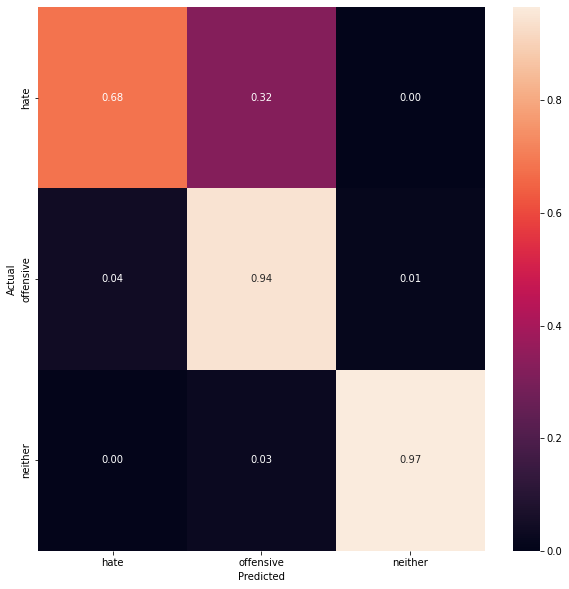

In [14]:
target_names = ("hate","offensive","neither")
cm = confusion_matrix(y_true=y_true,y_pred=y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Value Distributions

array([[<AxesSubplot:title={'center':'pred_label'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

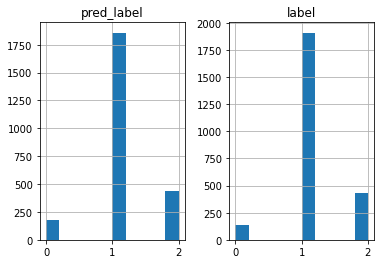

In [70]:
analysis_df[["pred_label","label"]].hist() #both frequencies are not a terrible missmatch, just a basic sanity check

## Data Exploration and Confusion Investigation

### Investigating High Loss Tweets

In [73]:
def get_top_loss(top_n:int) -> pd.DataFrame: 
    loss_df = analysis_df.sort_values(by="loss",ascending=False) # sorts the dataframe by the lossvalues in descending order
    return loss_df.head(top_n) # returns the top_n rows as a dataframe

def print_top_loss_tweets(top_n:int): #prints out the information and the tweet top_n tweets with the highest loss
    loss_df = get_top_loss(top_n)

    loss = list(loss_df.loss.values) 
    tweets = list(loss_df.tweets.values)
    val2class = {0:"hateful",1:"offensive",2:"neither"} # mapping the class-numbers to the class-names
    labels = [val2class[label] for label in list(loss_df.label.values)] 
    preds = [val2class[label] for label in list(loss_df.pred_label.values)]

    for i,tweet in enumerate(tweets): # iterate over all tweets and save the index to print appropriate information
        print("TWEET:", "PRED_LABEL:",preds[i], "LABEL:",labels[i] ,"LOSS:",loss[i],)
        print(tweet)
        print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

print_top_loss_tweets(10)

TWEET: PRED_LABEL: hateful LABEL: neither LOSS: 6.643801689147949
The republican teabaggers hate this but screw em. http://t.co/6iutHYvhQm
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
TWEET: PRED_LABEL: hateful LABEL: neither LOSS: 6.077870845794678
@TreyDoe_: @HallDerik @20ToLife_ once fag." You got pressed to the ground? ..hang up your cleats n never put them back on or think about it
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
TWEET: PRED_LABEL: neither LABEL: offensive LOSS: 5.587460517883301
RT @Jarhead44: Hi, can I buy you a margarita?

Sure!

So, I like the way your barstool shows off your clam.
-----------------------------------------------------

<AxesSubplot:>

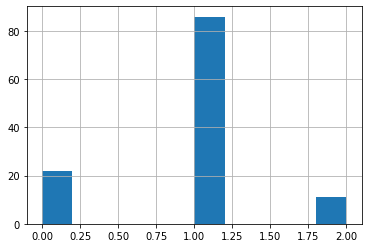

In [80]:
certainty= 0.9 
uncertain_df = confusion_df[(confusion_df["hate_%"] < certainty) & (confusion_df["offensive_%"] < certainty) & (confusion_df["neither_%"] < certainty)]
# this query finds labels where the model was uncertain (it was less than 90% confident in any prediction)
uncertain_df.label.hist() # for example for investigations like this where we can see that the model is more uncertain about gold-hateful tweets

In [76]:
confused_hateful_tweets = confusion_df[(confusion_df.label == 0) & (confusion_df.pred_label != 0)].tweets

## BERT Visualization

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=LAST_MODEL,output_attentions = True) #redefine model since the below listed models need output_attentions = True

loading configuration file ../results/training_begin=20220312-202358\config.json
Model config DistilBertConfig {
  "_name_or_path": "../results/last-model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_attentions": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "vocab_size": 30522
}

loading weights file ../results/training_begin=20220312-202358\pytorch_model.bin
All model c

In [33]:
input_text = analysis_df["tweets"].iloc[0]
inputs = tokenizer.encode(preprocess_tweet(input_text), return_tensors='pt')  # Tokenize input text 
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings

head_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

In [30]:

model_view(attention,tokens)

<IPython.core.display.Javascript object>